In [46]:
import sys
sys.path.append("..") if ".." not in sys.path else print("Already exists")
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import WeightedRandomSampler
from torchvision import models
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from utils.dataset import get_dataloader, MHCoverDataset
from utils.plots import EvaluationPlots
from utils.training import TrainingInterface

Already exists


## Load all runs as CSV

In [20]:
all_runs = pd.read_csv('wandb_export_2022-06-01T18_57_28.404+02_00.csv')
all_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 45 non-null     object 
 1   State                45 non-null     object 
 2   Notes                45 non-null     object 
 3   User                 45 non-null     object 
 4   Tags                 0 non-null      float64
 5   Created              45 non-null     object 
 6   Runtime              45 non-null     int64  
 7   MODEL_NAME           45 non-null     object 
 8   epoch                45 non-null     int64  
 9   Max-F1               0 non-null      float64
 10  Max-F1-EP            0 non-null      float64
 11  BATCH_SIZE           45 non-null     int64  
 12  LR                   45 non-null     float64
 13  PRETRAINED           45 non-null     bool   
 14  RA_MAGNITUDE         45 non-null     int64  
 15  RA_NUM_OPS           45 non-null     int64

<AxesSubplot:ylabel='best_score_at_epoch'>

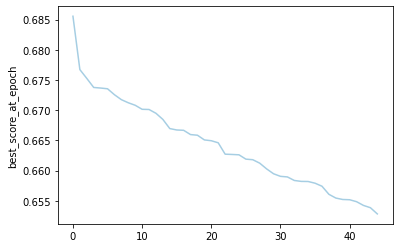

In [21]:
sns.lineplot(x=all_runs.index, y = all_runs['best_score_at_epoch'])

In [22]:
all_runs = all_runs.head(20)

In [23]:
all_runs = all_runs[['Name', 'BATCH_SIZE', 'LR','RA_MAGNITUDE', 'RA_NUM_OPS', 'SAMPLER_NUM_SAMPLES', 
                     'SAMPLER_REPLACEMENT', 'WEIGHTED_LOSS', 'WEIGHTED_SAMPLER', 
                     'WEIGHT_DECAY', 'best_val_score', 'best_score_at_epoch']]

In [24]:
for idx in range(1):
    params = all_runs.loc[idx].to_dict()
    print(params)

{'Name': 'kind-energy-211', 'BATCH_SIZE': 16, 'LR': 9.46974391861e-05, 'RA_MAGNITUDE': 6, 'RA_NUM_OPS': 3, 'SAMPLER_NUM_SAMPLES': 2773, 'SAMPLER_REPLACEMENT': True, 'WEIGHTED_LOSS': True, 'WEIGHTED_SAMPLER': False, 'WEIGHT_DECAY': 0.3003739776970799, 'best_val_score': 54, 'best_score_at_epoch': 0.6855569772005811}


# WeightedRandomSampling

### Initiate Dataloaders

In [26]:
def init_transforms(ra_num_ops: int, ra_magnitude: int):
    """Initializes Transforms"""
    train_transformations = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.RandAugment(num_ops=ra_num_ops, magnitude=ra_magnitude),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ]
    )

    test_transformations = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ]
    )

    inverse_transforms = transforms.Compose(
        [
            transforms.Normalize(mean=[0, 0, 0], 
                                 std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                 std=[1, 1, 1]),
        ]
    )
    return (train_transformations, test_transformations, inverse_transforms)
    

def load_and_get_weights_train(df): 
    """Loads and get the weights of the train dataframe"""
    train = df[df["set"] == "train"].sample(frac=1).reset_index(drop=True)
    
    # Get the inverse label weight
    label_counts = train.shape[0] / (
    train["label"].unique().shape[0] * train["label"].value_counts()
    )
    train["weight"] = train["label"].apply(lambda x: label_counts[x])
    
    return train

def load_and_get_weights(df):
    """Loads and get the weights of the train dataframe"""
    train = df.sample(frac=1).reset_index(drop=True)
    
    # Get the inverse label weight
    label_counts = train.shape[0] / (
    train["label"].unique().shape[0] * train["label"].value_counts()
    )
    train["weight"] = train["label"].apply(lambda x: label_counts[x])
    
    return train
 
def get_max_score_from_epoch(scores, epoch_space):
    """Returns max score from epoch."""
    tmp = pd.DataFrame.from_dict(scores)
   
    return epoch_space[np.argmax(tmp["test"])]
    

In [44]:
RUN = False

if RUN:
    for idx in range(all_runs.shape[0]):
        params = all_runs.loc[idx].to_dict()
        print('Params for this Iter:\n', params)

        print(20*'-', 'Load Dataframe', 20*'-')
        df = pd.read_csv("../data/labels.csv") 
        train = load_and_get_weights_train(df)

        # Train iterative
        ####### Hyperparameters ########
        NAME = params['Name']

        print(20*'-', 'Assign Parameters', 20*'-')
        ## Sampler
        WEIGHTED_SAMPLER = False
        SAMPLER_NUM_SAMPLES = params['SAMPLER_NUM_SAMPLES']
        SAMPLER_REPLACEMENT = params['SAMPLER_REPLACEMENT']

        ## General
        WORKERS = 20
        BATCH_SIZE = params['BATCH_SIZE']

        ## Model
        PRETRAINED = True

        ## Training
        LR = params['LR']
        WEIGHT_DECAY = params['WEIGHT_DECAY']
        WEIGHTED_LOSS = params['WEIGHTED_LOSS']
        #EPOCHS = 2
        EPOCHS = params['best_val_score']

        # RandAugment Param
        NUM_OPS = params['RA_NUM_OPS']
        MAGNITUDE = params['RA_MAGNITUDE']

        # init Transforms
        print(20*'-', 'Get Dataloaders', 20*'-')
        train_transformations, test_transformations, inverse_transforms = init_transforms(ra_num_ops=NUM_OPS, ra_magnitude=MAGNITUDE)

        print(20*'-', 'Init Samplers', 20*'-')
        ########### Sampler #############
        if WEIGHTED_SAMPLER:
            sampler = WeightedRandomSampler(
                weights=train["weight"].to_numpy(),
                num_samples=SAMPLER_NUM_SAMPLES,
                replacement=SAMPLER_REPLACEMENT,
            )

        if WEIGHTED_SAMPLER:
            dataloader_train = get_dataloader(
                root_dir="../data/train/",
                df=train,
                fp_label_translator="../utils/dataset/label_translate.pkl",
                transformations=train_transformations,
                batch_size=BATCH_SIZE,
                workers=WORKERS,
                pin_memory=True,
                shuffle=False,
                sampler=sampler,
            )
        else:
            dataloader_train = get_dataloader(
                root_dir="../data/train/",
                df=train,
                fp_label_translator="../utils/dataset/label_translate.pkl",
                transformations=train_transformations,
                batch_size=BATCH_SIZE,
                workers=WORKERS,
                pin_memory=True,
                shuffle=True,
            )

        dataloader_val = get_dataloader(
            root_dir="../data/val/",
            df=df[df["set"] == "val"].reset_index(drop=True),
            fp_label_translator="../utils/dataset/label_translate.pkl",
            transformations=test_transformations,
            batch_size=BATCH_SIZE,
            workers=12,
            pin_memory=True,
            shuffle=True,
        )
        dataloader_test = get_dataloader(
            root_dir="../data/test/",
            df=df[df["set"] == "test"].reset_index(drop=True),
            fp_label_translator="../utils/dataset/label_translate.pkl",
            transformations=test_transformations,
            batch_size=BATCH_SIZE,
            workers=WORKERS,
            pin_memory=True,
            shuffle=True,
        )

        # Test correctness of labels 
        assert dataloader_train.dataset.label_dict == dataloader_val.dataset.label_dict
        assert dataloader_val.dataset.label_dict == dataloader_test.dataset.label_dict

        # Load model
        print(20*'-', 'Prepare Model', 20*'-')
        resnet_ = models.resnet18(pretrained=PRETRAINED, 
                                  progress=True)

        if PRETRAINED:
            for param in resnet_.parameters():
                param.requires_grad = False

            # Replace fc
            resnet_.fc = nn.Linear(512, len(dataloader_train.dataset.label_dict.keys()))

            # Enable grad
            resnet_.fc.weight.requires_grad = True
            resnet_.fc.bias.requires_grad = True

            # check
            for name, param in resnet_.named_parameters():
                if param.requires_grad:
                    print("Requires Grad:", name)
        else:
            resnet_.fc = nn.Linear(512, len(dataloader_train.dataset.label_dict.keys()))

        resnet = TrainingInterface(
            model=resnet_, 
            name=NAME,
            history=False, 
            writer=None
        )

        if WEIGHTED_LOSS:
            train.groupby("label").first()["weight"]
            ce_weights = [
                train.loc[train["label"] == key, "weight"].iloc[0]
                for key in dataloader_train.dataset.label_dict.keys()
            ]
            criterion = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights))
            optimizer = optim.Adam(
                resnet.model.parameters(), 
                lr=LR, 
                weight_decay=WEIGHT_DECAY
            )
        else:
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(
                resnet.model.parameters(), 
                lr=LR, 
                weight_decay=WEIGHT_DECAY
            )
        print(20*'-', 'Start Training', 20*'-')
        ## Start Trainnig
        resnet.train(
            criterion=criterion,
            optimizer=optimizer,
            n_epochs=EPOCHS,
            dataloader_train=dataloader_train,
            dataloader_val=dataloader_val,
            verbose=True,
            score_func=f1_score,
            average='macro'
        )

        torch.save(resnet.model, f'./models/{NAME}.pth')

## Validation of best Model

In [59]:
all_metrics = {}
model_dir = './models/'
for model_name in [f for f in os.listdir('./models/') if f.endswith('.pth')]:
    model_path = os.path.join(model_dir, model_name)    

    interface = TrainingInterface(model=torch.load(model_path, map_location='cuda'), name = model_name)
    
    model_metrics = interface.calculate_metrics(dataloader_train=dataloader_val, 
                                                dataloader_test = dataloader_test, 
                                                metric_funcs=[f1_score, recall_score, precision_score], 
                                                average='macro', 
                                                disable_pbar=True)
    all_metrics[model_name] = model_metrics

/users/sstaehli/manhole-cover-classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

/users/sstaehli/manhole-cover-classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/users/sstaehli/manhole-cover-classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

/users/sstaehli/manhole-cover-classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

Predictions Train-Set:   0%|          | 0/13 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/14 [00:00<?, ?it/s]

In [93]:
df_metrics = pd.DataFrame()
for k in tqdm(all_metrics.keys()):
    tmp = pd.DataFrame.from_dict(all_metrics[k])
    tmp['name'] = k
    tmp = tmp.reset_index()
    tmp = tmp.rename(columns={'index':'metric', 'train':'val'})
    df_metrics = pd.concat([df_metrics, tmp], axis = 0)

  0%|          | 0/20 [00:00<?, ?it/s]

In [153]:
def plot_metric_comparisson(metrics: dict, metric: str = 'f1_score'):
    df_metrics = pd.DataFrame()
    for k in tqdm(all_metrics.keys()):
        tmp = pd.DataFrame.from_dict(all_metrics[k])
        tmp['name'] = k
        tmp = tmp.reset_index()
        tmp = tmp.rename(columns={'index':'metric', 'train':'val'})
        df_metrics = pd.concat([df_metrics, tmp], axis = 0)
        
    f1_metric = df_metrics[df_metrics['metric']==metric]
    sns.set_style('whitegrid')

    fig,ax = plt.subplots(figsize=(10, 6))
    p = sns.scatterplot(x=f1_metric['val'], y=f1_metric['name'], label='Validation', s=100)
    p = sns.scatterplot(x=f1_metric['test'], y=f1_metric['name'], label='Test', s=100)
    sns.despine()
    i = 0
    p.set_title('Comparisson of Top Models')
    p.set_xlabel(metric)
    p.set_ylabel('')
    for idx, values in f1_metric.iterrows():
        plt.hlines(y=i, xmin=values.val, xmax=values.test, color='black',  linewidth=.4)
        i+=1
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

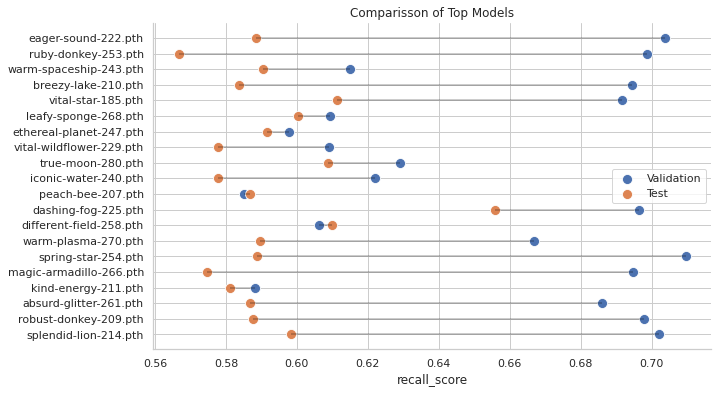

In [154]:
plot_metric_comparisson(all_metrics, 'recall_score')

  0%|          | 0/20 [00:00<?, ?it/s]

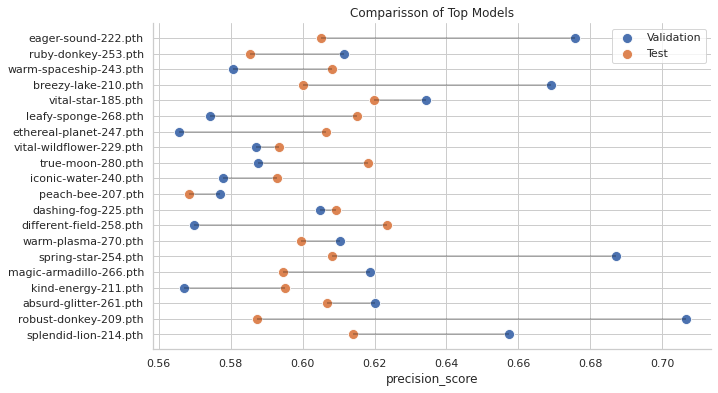

In [155]:
plot_metric_comparisson(all_metrics, 'precision_score')

  0%|          | 0/20 [00:00<?, ?it/s]

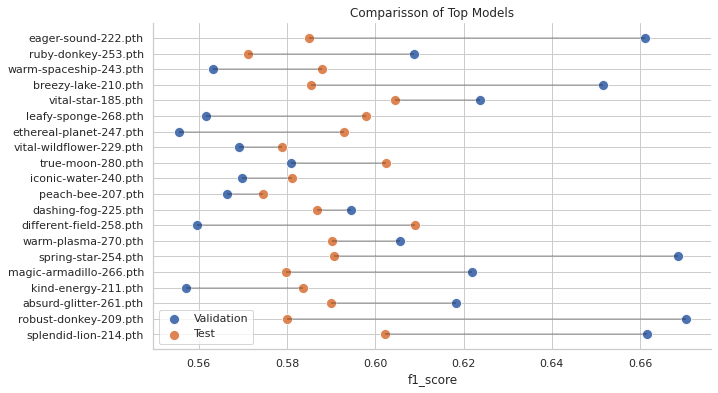

In [156]:
plot_metric_comparisson(all_metrics, 'f1_score')

In [54]:
dataloader_test = get_dataloader(
            root_dir="../data/test/",
            df=df[df["set"] == "test"].reset_index(drop=True),
            fp_label_translator="../utils/dataset/label_translate.pkl",
            transformations=test_transformations,
            batch_size=BATCH_SIZE,
            workers=WORKERS,
            pin_memory=True,
            shuffle=True,
)

In [55]:
best_run = all_runs[all_runs['Name'] == 'vital-star-185']

In [56]:
best_run['Name'].values[0]

'vital-star-185'

In [57]:
model_dir = './models/'
model_name = best_run['Name'].values[0]+'.pth'
model_path = os.path.join(model_dir, model_name)    

interface = TrainingInterface(model=torch.load(model_path, map_location='cuda'), name = model_name)

y_true, y_pred, _, prob  = interface.predict(dataloader=dataloader_test, return_images= False, 
                                   return_prob = True, 
                                    disable_pbar = False)

Calculate Predictions:   0%|          | 0/14 [00:00<?, ?it/s]

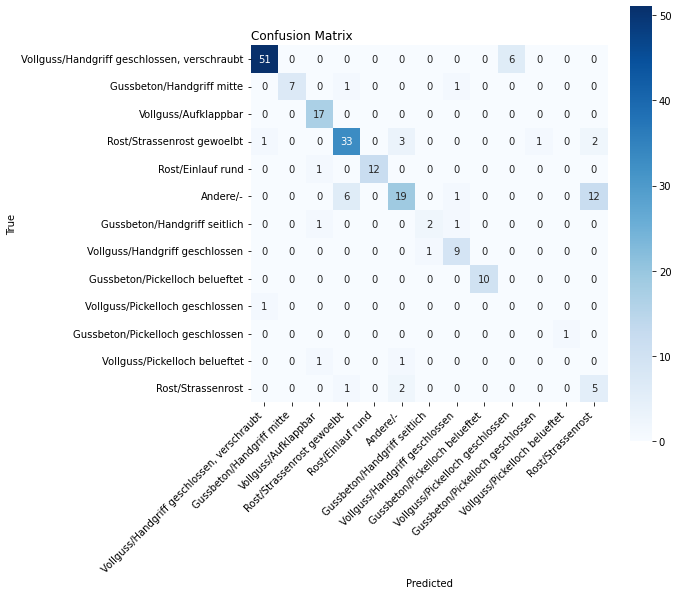

In [64]:
EvaluationPlots.plot_confusion_matrix(y_true, y_pred, 
                                      dict(zip(list(label_dict.values())[::-1], list(label_dict.keys())[::-1])))

## Train final model

In [9]:
all_runs.head(2)

,Name,BATCH_SIZE,LR,RA_MAGNITUDE,RA_NUM_OPS,SAMPLER_NUM_SAMPLES,SAMPLER_REPLACEMENT,WEIGHTED_LOSS,WEIGHTED_SAMPLER,WEIGHT_DECAY,best_val_score,best_score_at_epoch
0,kind-energy-211,16,0.000095,6,3,2773,True,True,False,0.300374,54,0.685557
1,robust-donkey-209,16,0.000052,9,3,1248,True,True,False,0.282245,81,0.676720


In [16]:
best_run = all_runs[all_runs['Name'] == 'vital-star-185']
best_run

,Name,BATCH_SIZE,LR,RA_MAGNITUDE,RA_NUM_OPS,SAMPLER_NUM_SAMPLES,SAMPLER_REPLACEMENT,WEIGHTED_LOSS,WEIGHTED_SAMPLER,WEIGHT_DECAY,best_val_score,best_score_at_epoch
4,vital-star-185,16,0.000093,8,3,2287,True,True,False,0.20477,76,0.673668


In [42]:
best_run.T.to_dict()[best_run.T.columns[0]]

{'Name': 'vital-star-185',
 'BATCH_SIZE': 16,
 'LR': 9.25535400225e-05,
 'RA_MAGNITUDE': 8,
 'RA_NUM_OPS': 3,
 'SAMPLER_NUM_SAMPLES': 2287,
 'SAMPLER_REPLACEMENT': True,
 'WEIGHTED_LOSS': True,
 'WEIGHTED_SAMPLER': False,
 'WEIGHT_DECAY': 0.204769989118369,
 'best_val_score': 76,
 'best_score_at_epoch': 0.6736680424825754}

In [48]:
RUN = True

if RUN:
    params = best_run.T.to_dict()[best_run.T.columns[0]]
    print('Params for this Iter:\n', params)

    print(20*'-', 'Load Dataframe', 20*'-')
    df = pd.read_csv("../data/labels.csv") 
    df = load_and_get_weights(df)

    # Train iterative
    ####### Hyperparameters ########
    NAME = params['Name']

    print(20*'-', 'Assign Parameters', 20*'-')
    ## Sampler
    WEIGHTED_SAMPLER = False
    SAMPLER_NUM_SAMPLES = params['SAMPLER_NUM_SAMPLES']
    SAMPLER_REPLACEMENT = params['SAMPLER_REPLACEMENT']

    ## General
    WORKERS = 20
    BATCH_SIZE = params['BATCH_SIZE']

    ## Model
    PRETRAINED = True

    ## Training
    LR = params['LR']
    WEIGHT_DECAY = params['WEIGHT_DECAY']
    WEIGHTED_LOSS = params['WEIGHTED_LOSS']
    #EPOCHS = 2
    EPOCHS = params['best_val_score']

    # RandAugment Param
    NUM_OPS = params['RA_NUM_OPS']
    MAGNITUDE = params['RA_MAGNITUDE']

    # init Transforms
    print(20*'-', 'Get Dataloaders', 20*'-')
    train_transformations, test_transformations, inverse_transforms = init_transforms(ra_num_ops=NUM_OPS, ra_magnitude=MAGNITUDE)

    print(20*'-', 'Init Samplers', 20*'-')

    # Prepare whole Dataset
    train_set = MHCoverDataset(
        root_dir="../data/train/",
        df=df[df['set']=='train'].reset_index(drop=True),
        fp_label_translator="../utils/dataset/label_translate.pkl",
        transform=train_transformations
    )

    val_set = MHCoverDataset(
        root_dir="../data/val/",
        df=df[df["set"] == "val"].reset_index(drop=True),
        fp_label_translator="../utils/dataset/label_translate.pkl",
        transform=train_transformations,
    )
    test_set = MHCoverDataset(
        root_dir="../data/test/",
        df=df[df["set"] == "test"].reset_index(drop=True),
        fp_label_translator="../utils/dataset/label_translate.pkl",
        transform=train_transformations,
    )
    label_dict = pickle.load(open('../utils/dataset/label_translate.pkl', 'rb'))

    all_sets = torch.utils.data.ConcatDataset([train_set,
                                               val_set,
                                               test_set])

    dataloader_train = torch.utils.data.DataLoader(dataset=all_sets, 
                                                   batch_size=BATCH_SIZE, 
                                                   num_workers=12, 
                                                   pin_memory=True, 
                                                   shuffle=True)


    # Load model
    print(20*'-', 'Prepare Model', 20*'-')
    resnet_ = models.resnet18(pretrained=PRETRAINED, 
                              progress=True)

    if PRETRAINED:
        for param in resnet_.parameters():
            param.requires_grad = False

        # Replace fc
        resnet_.fc = nn.Linear(512, len(label_dict.keys()))

        # Enable grad
        resnet_.fc.weight.requires_grad = True
        resnet_.fc.bias.requires_grad = True

        # check
        for name, param in resnet_.named_parameters():
            if param.requires_grad:
                print("Requires Grad:", name)
    else:
        resnet_.fc = nn.Linear(512, len(label_dict.keys()))

    resnet = TrainingInterface(
        model=resnet_, 
        name=NAME,
        history=False, 
        writer=None
    )

    if WEIGHTED_LOSS:
        df.groupby("label").first()["weight"]
        ce_weights = [
            df.loc[df["label"] == key, "weight"].iloc[0]
            for key in label_dict.keys()
        ]
        criterion = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights))
        optimizer = optim.Adam(
            resnet.model.parameters(), 
            lr=LR, 
            weight_decay=WEIGHT_DECAY
        )
    else:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(
            resnet.model.parameters(), 
            lr=LR, 
            weight_decay=WEIGHT_DECAY
        )
    print(20*'-', 'Start Training', 20*'-')
    ## Start Trainnig
    resnet.train(
        criterion=criterion,
        optimizer=optimizer,
        n_epochs=EPOCHS,
        dataloader_train=dataloader_train,
        dataloader_val=None,
        verbose=True,
        score_func=f1_score,
        average='macro'
    )

    torch.save(resnet.model, f'./models/best_{NAME}.pth')

Params for this Iter:
 {'Name': 'vital-star-185', 'BATCH_SIZE': 16, 'LR': 9.25535400225e-05, 'RA_MAGNITUDE': 8, 'RA_NUM_OPS': 3, 'SAMPLER_NUM_SAMPLES': 2287, 'SAMPLER_REPLACEMENT': True, 'WEIGHTED_LOSS': True, 'WEIGHTED_SAMPLER': False, 'WEIGHT_DECAY': 0.204769989118369, 'best_val_score': 76, 'best_score_at_epoch': 0.6736680424825754}
-------------------- Load Dataframe --------------------
-------------------- Assign Parameters --------------------
-------------------- Get Dataloaders --------------------
-------------------- Init Samplers --------------------
-------------------- Prepare Model --------------------
Requires Grad: fc.weight
Requires Grad: fc.bias
-------------------- Start Training --------------------


  0%|          | 0/10412 [00:00<?, ?it/s]

Epoch 1/76: [Train-Loss = 352.215] || [Validation-Loss = 0.0]
Epoch 2/76: [Train-Loss = 313.605] || [Validation-Loss = 0.0]
Epoch 3/76: [Train-Loss = 288.714] || [Validation-Loss = 0.0]
Epoch 4/76: [Train-Loss = 271.49] || [Validation-Loss = 0.0]
Epoch 5/76: [Train-Loss = 255.541] || [Validation-Loss = 0.0]
Epoch 6/76: [Train-Loss = 243.697] || [Validation-Loss = 0.0]
Epoch 7/76: [Train-Loss = 232.417] || [Validation-Loss = 0.0]
Epoch 8/76: [Train-Loss = 225.594] || [Validation-Loss = 0.0]
Epoch 9/76: [Train-Loss = 219.856] || [Validation-Loss = 0.0]
Epoch 10/76: [Train-Loss = 210.779] || [Validation-Loss = 0.0]
Epoch 11/76: [Train-Loss = 202.9] || [Validation-Loss = 0.0]
Epoch 12/76: [Train-Loss = 206.145] || [Validation-Loss = 0.0]
Epoch 13/76: [Train-Loss = 195.679] || [Validation-Loss = 0.0]
Epoch 14/76: [Train-Loss = 196.697] || [Validation-Loss = 0.0]
Epoch 15/76: [Train-Loss = 194.251] || [Validation-Loss = 0.0]
Epoch 16/76: [Train-Loss = 187.478] || [Validation-Loss = 0.0]
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 70/76: [Train-Loss = 159.988] || [Validation-Loss = 0.0]
Epoch 71/76: [Train-Loss = 160.856] || [Validation-Loss = 0.0]
Epoch 72/76: [Train-Loss = 160.274] || [Validation-Loss = 0.0]
Epoch 73/76: [Train-Loss = 163.208] || [Validation-Loss = 0.0]
Epoch 74/76: [Train-Loss = 159.415] || [Validation-Loss = 0.0]
Epoch 75/76: [Train-Loss = 159.696] || [Validation-Loss = 0.0]
Epoch 76/76: [Train-Loss = 156.575] || [Validation-Loss = 0.0]
